<a href="https://colab.research.google.com/github/yoyoyo-yo/DCGAN_keras/blob/master/notes_pytorch/ImgRec/SEResNeXt_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SE-ResNeXt

元論文 >> Squeeze-and-Excitation Networks https://arxiv.org/abs/1709.01507 (2017)

Squeeze と Excitationのブロックを追加したもの。

SEブロックはまず、Global poolingをいれることで、特徴マップ全体の各チャンネルのグローバルなreceptive fieldを集約して、Fully Connected層で次元圧縮する（これがsqueeze)。そのあと、元のチャンネル数に戻してSigmoidをかませることで、いわゆるattentionを作る（これがExitation)。

ResNetやResNeXtのブロック内にいれることで、ちょっと計算コストを増える代わりに精度を向上させた。


In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 952kB 28.7MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 


# scratch

## SE-ResNeXt

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w

    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x


class SEResNeXtBlock(nn.Module):
    def __init__(self, in_f, f_1, out_f, stride=1, cardinality=32, se_r=16):
        super(SEResNeXtBlock, self).__init__()

        self.stride = stride
        self.fit_dim = False
        
        self.res = nn.Sequential(
            nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
            nn.BatchNorm2d(f_1),
            nn.ReLU(),
            nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1, groups=cardinality),
            nn.BatchNorm2d(f_1),
            nn.ReLU(),
            nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(out_f),
            nn.ReLU(),
        )

        self.se = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            Flatten(),
            nn.Linear(out_f, out_f // se_r),
            nn.ReLU(),
            nn.Linear(out_f // se_r, out_f),
            nn.Sigmoid(),
            Reshape(out_f, 1, 1)
        )

        if in_f != out_f:
            self.fit_conv = nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
            self.fit_dim = True
    
    def forward(self, x):
        res_x = self.res(x)

        # se block
        seblock_x = self.se(res_x)
        _, _, h, w = res_x.size()
        seblock_x = F.interpolate(seblock_x, scale_factor=[h, w])
        res_x = torch.mul(res_x, seblock_x)
        
        if self.fit_dim:
            x = self.fit_conv(x)
        
        if self.stride == 2:
            x = F.max_pool2d(x, 2, stride=2)
            
        x = torch.add(x, res_x)
        x = F.relu(x)
        return x


class SEResNeXt(nn.Module):
    def __init__(self, out_dim, resnext=50):
        super(SEResNeXt, self).__init__()
        
        if resnext == 50:
            self.module = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d([3, 3], padding=1, stride=2),
                SEResNeXtBlock(64, 128, 256), # block2
                SEResNeXtBlock(256, 128, 256),
                SEResNeXtBlock(256, 128, 256),
                SEResNeXtBlock(256, 256, 512, stride=2), # block3
                SEResNeXtBlock(512, 256, 512),
                SEResNeXtBlock(512, 256, 512),
                SEResNeXtBlock(512, 256, 512),
                SEResNeXtBlock(512, 512, 1024, stride=2), # block4
                SEResNeXtBlock(1024, 512, 1024),
                SEResNeXtBlock(1024, 512, 1024),
                SEResNeXtBlock(1024, 512, 1024),
                SEResNeXtBlock(1024, 512, 1024),
                SEResNeXtBlock(1024, 512, 1024),
                SEResNeXtBlock(1024, 1024, 2048, stride=2), # block5
                SEResNeXtBlock(2048, 1024, 2048),
                SEResNeXtBlock(2048, 1024, 2048),
            )
        
        elif resnext == 101:
            block = []
            for _ in range(22):
                block.append(SEResNeXtBlock(1024, 512, 1024))
            resblock4s = nn.Sequential(*block)
            
            self.module = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d([3, 3], padding=1, stride=2),
                SEResNeXtBlock(64, 128, 256), # block2
                SEResNeXtBlock(256, 128, 256),
                SEResNeXtBlock(256, 128, 256),
                SEResNeXtBlock(256, 256, 512, stride=2), # block3
                SEResNeXtBlock(512, 256, 512),
                SEResNeXtBlock(512, 256, 512),
                SEResNeXtBlock(512, 256, 512),
                SEResNeXtBlock(512, 512, 1024, stride=2), # block4
                resblock4s,
                SEResNeXtBlock(1024, 1024, 2048, stride=2), # block5
                SEResNeXtBlock(2048, 1024, 2048),
                SEResNeXtBlock(2048, 1024, 2048),
            )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.top = nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)
        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.top(x)
        return x

# Import

In [11]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [12]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [13]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Files already downloaded and verified


In [14]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [15]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        model = SEResNeXt(out_dim=10, resnext=50)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys) / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.4050 acc:0.1964  [val]loss:1.9812 acc:0.2570  [time]total:34.30sec tra:27.84sec val:6.45sec
fold:1 epoch:2/30 [tra]loss:2.0041 acc:0.2650  [val]loss:2.2485 acc:0.2890  [time]total:33.81sec tra:27.29sec val:6.52sec
fold:1 epoch:3/30 [tra]loss:1.8764 acc:0.3164  [val]loss:1.8515 acc:0.3163  [time]total:34.08sec tra:27.47sec val:6.60sec
fold:1 epoch:4/30 [tra]loss:1.8341 acc:0.3431  [val]loss:1.7764 acc:0.3449  [time]total:33.98sec tra:27.36sec val:6.62sec
fold:1 epoch:5/30 [tra]loss:1.8009 acc:0.3559  [val]loss:2.0170 acc:0.3944  [time]total:34.67sec tra:28.00sec val:6.67sec
fold:1 epoch:6/30 [tra]loss:1.7471 acc:0.3766  [val]loss:1.6730 acc:0.3930  [time]total:34.03sec tra:27.37sec val:6.67sec
fold:1 epoch:7/30 [tra]loss:1.7377 acc:0.3806  [val]loss:1.7193 acc:0.4356  [time]total:34.12sec tra:27.39sec val:6.73sec
fold:1 epoch:8/30 [tra]loss:1.7115 acc:0.3938  [val]loss:1.5791 acc:0.4373  [time]total:34.24s

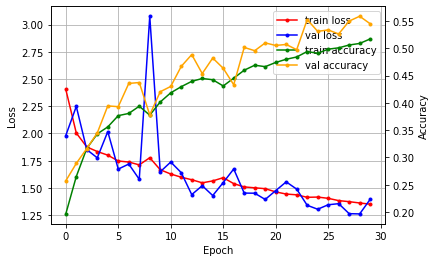

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.4987 acc:0.1837  [val]loss:3.4762 acc:0.2632  [time]total:34.19sec tra:27.40sec val:6.80sec
fold:2 epoch:2/30 [tra]loss:1.9870 acc:0.2634  [val]loss:1.9893 acc:0.2937  [time]total:34.47sec tra:27.69sec val:6.78sec
fold:2 epoch:3/30 [tra]loss:1.8950 acc:0.3110  [val]loss:2.7733 acc:0.3056  [time]total:34.31sec tra:27.51sec val:6.79sec
fold:2 epoch:4/30 [tra]loss:1.8245 acc:0.3424  [val]loss:11.9036 acc:0.3539  [time]total:34.29sec tra:27.49sec val:6.80sec
fold:2 epoch:5/30 [tra]loss:1.7785 acc:0.3592  [val]loss:1.7206 acc:0.3818  [time]total:34.29sec tra:27.48sec val:6.81sec
fold:2 epoch:6/30 [tra]loss:1.7577 acc:0.3663  [val]loss:1.8705 acc:0.3823  [time]total:34.23sec tra:27.49sec val:6.74sec
fold:2 epoch:7/30 [tra]loss:1.7275 acc:0.3774  [val]loss:1.7119 acc:0.3729  [time]total:34.40sec tra:27.57sec val:6.84sec
fold:2 epoch:8/30 [tra]loss:1.7265 acc:0.3823  [val]loss:1.9492 acc:0.3905  [time]total:34.34

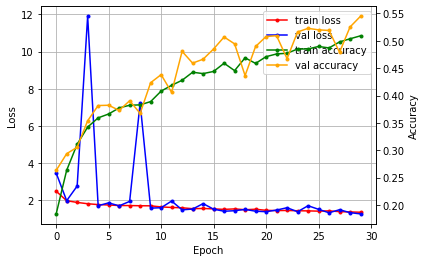

all folds score
total loss:1.335948, accuracy:0.544980
fold1/2 loss:1.394655, accuracy:0.545000
fold2/2 loss:1.277240, accuracy:0.544960

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,3174,319,242,56,29,48,33,74,761,264
1,232,3752,36,41,5,31,39,81,67,716
2,741,191,2267,245,295,290,405,326,155,85
3,342,214,386,1825,116,685,718,277,155,282
4,285,62,962,234,1881,118,610,657,89,102
5,214,170,365,1206,149,1755,392,411,140,198
6,125,148,383,245,192,67,3583,103,54,100
7,273,168,318,307,206,308,160,2894,68,298
8,785,476,71,57,17,52,34,51,3228,229


In [22]:
train_models, train_model_paths = train()

# Test

In [23]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.5695 (5695 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,625,61,34,12,3,5,7,16,196,41
1,41,797,2,6,0,2,5,7,7,133
2,138,35,476,43,55,64,92,62,22,13
3,59,45,72,391,32,122,148,49,35,47
4,45,12,205,30,385,18,122,138,25,20
5,36,29,72,240,25,375,77,76,37,33
6,21,32,68,41,24,11,766,20,8,9
7,76,26,54,57,23,72,31,615,10,36
8,153,93,10,6,2,13,7,9,663,44
